In [1]:
import cv2 as cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.spatial.distance import pdist

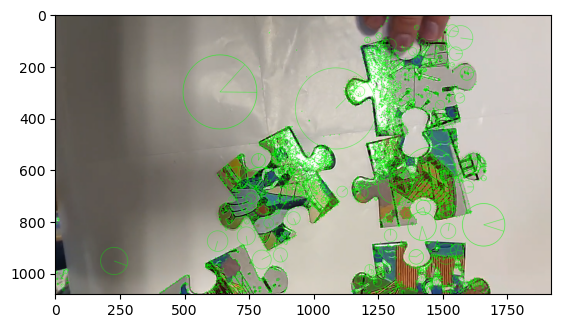

In [2]:
puzzle_full = cv2.imread('screenshots/screenshot_3.png')
sift = cv2.SIFT_create()

puzzle_full_gray = cv2.cvtColor(puzzle_full, cv2.COLOR_BGR2GRAY)
keypoints_full, descriptors_full = sift.detectAndCompute(puzzle_full_gray, None)

image_with_keypoints = cv2.drawKeypoints(
    puzzle_full, 
    keypoints_full, 
    None,
    color=(0, 255, 0),  # Green might be more visible
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))

matches_img = cv2.draw

In [3]:
def extract_pieces(frame):
        """Extract multiple puzzle pieces from the camera frame."""
        try:
            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            
            # Apply adaptive thresholding
            binary = cv2.adaptiveThreshold(
                blurred,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                blockSize=11,  # Must be odd number
                C=2  # Constant subtracted from mean
            )
            

            # Morphological operations with smaller kernel
            kernel_small = np.ones((3, 3), np.uint8)
            kernel_medium = np.ones((8, 8), np.uint8)
            #kernel_large = np.ones((15, 15), np.uint8)
            
            # Close small holes first
            #morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_large)
            morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_medium)
            morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel_small)
            
            contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            mask = np.zeros_like(morph)
            
            for contour in contours:
                # Fill each contour
                cv2.drawContours(mask, [contour], -1, 255, -1)
            
            # Now mask has filled pieces without holes
            morph = mask
            
            plt.figure(figsize=(12, 4))
            plt.subplot(121)
            plt.imshow(binary, cmap='gray')
            plt.title("Adaptive Threshold")
            plt.subplot(122)
            plt.imshow(morph, cmap='gray')
            plt.title("Morphological")
            plt.show()
            
            # Find connected components
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph, connectivity=8)
            pieces = []
            
            # Calculate minimum area threshold based on image size
            min_area = frame.shape[0] * frame.shape[1] * 0.02  # 2% of image area
            max_area = frame.shape[0] * frame.shape[1] * 0.5   # 50% of image area
            
            # Skip label 0 as it's background
            for i in range(1, num_labels):
                x, y, w, h, area = stats[i]
                
                # Filter out components that are too small or too large
                if area < min_area or area > max_area:
                    continue
                
                # Get the mask for this specific piece
                piece_mask = (labels == i).astype(np.uint8)
                
                # Dilate the mask slightly to include edges
                piece_mask = cv2.dilate(piece_mask, kernel_small)
                
                # Extract the piece with dynamic padding based on piece size
                padding = min(20, min(w, h) // 4)  # Dynamic padding
                x_start = max(0, x - padding)
                y_start = max(0, y - padding)
                x_end = min(frame.shape[1], x + w + padding)
                y_end = min(frame.shape[0], y + h + padding)
                
                # Extract the piece region
                piece_img = frame[y_start:y_end, x_start:x_end].copy()
                piece_mask = piece_mask[y_start:y_end, x_start:x_end]
                
                # Ensure mask has enough content
                if np.sum(piece_mask) < area * 0.5:  # At least 50% of original area
                    continue
                
                # Create white background version for feature matching
                white_bg = np.full_like(piece_img, 255)
                piece_mask_3d = np.stack([piece_mask] * 3, axis=-1)
                piece_on_white = np.where(piece_mask_3d == 1, piece_img, white_bg)
                
                pieces.append({
                    'image': piece_img,
                    'matching_image': piece_on_white,
                    'binary_mask': piece_mask,
                    'position': (x_start, y_start),
                    'size': (x_end - x_start, y_end - y_start),
                    'area': area
                })
            
            print(f"Found {len(pieces)} valid pieces")
            if pieces:
                print("Piece areas:", [p['area'] for p in pieces])
                
            return pieces

        except Exception as e:
            print(f"Error in extract_pieces: {e}")
            import traceback
            traceback.print_exc()
            return []

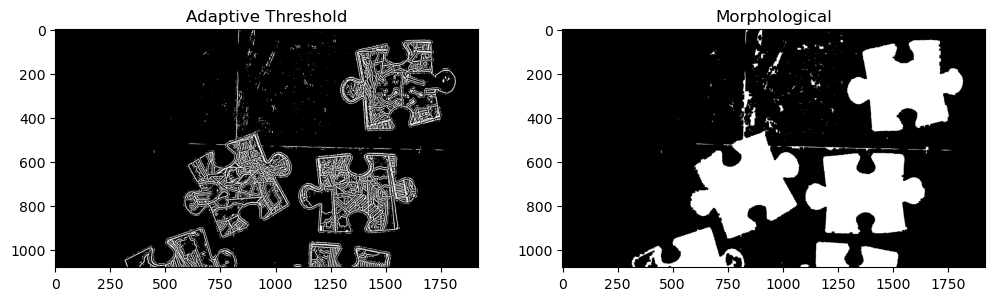

Found 3 valid pieces
Piece areas: [136588, 139533, 133519]


In [4]:
image = cv2.imread('screenshots\screenshot_4.png')
pieces = extract_pieces(image)


Piece 0:
Position: (1275, 29)
Size: (565, 456)
Area: 136588

Piece 1:
Position: (563, 171)
Size: (535, 800)
Area: 139533

Piece 2:
Position: (1085, 540)
Size: (582, 411)
Area: 133519


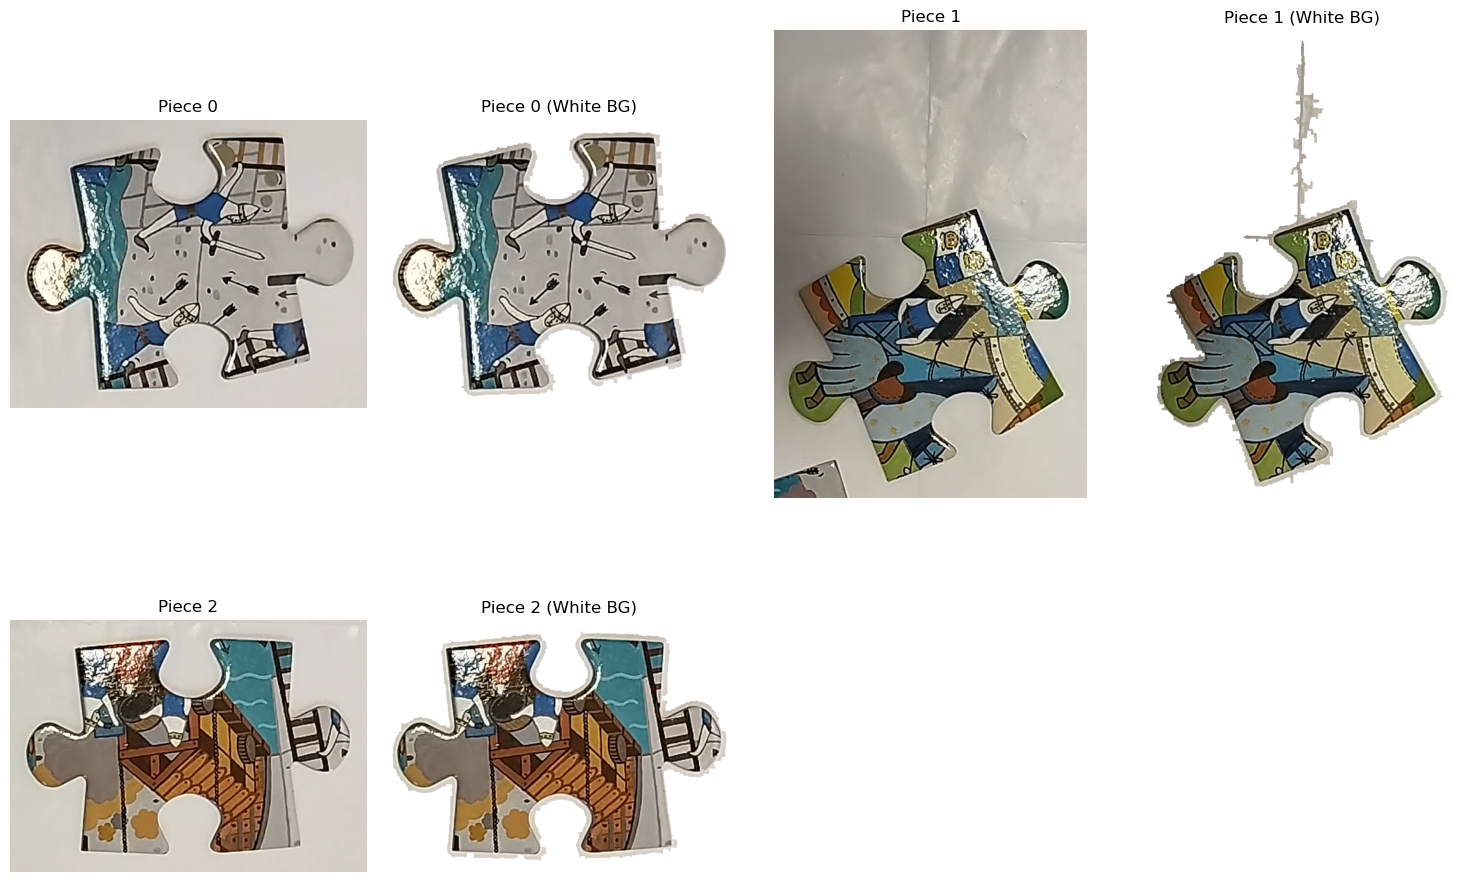

In [5]:
n_pieces = len(pieces)
if n_pieces > 0:
    rows = (n_pieces + 1) // 2  # 2 pieces per row
    plt.figure(figsize=(15, 5*rows))
    
    for i, piece in enumerate(pieces):
        # Original image
        plt.subplot(rows, 4, i*2 + 1)
        plt.imshow(cv2.cvtColor(piece['image'], cv2.COLOR_BGR2RGB))
        plt.title(f"Piece {i}")
        plt.axis('off')
        
        # White background version
        plt.subplot(rows, 4, i*2 + 2)
        plt.imshow(cv2.cvtColor(piece['matching_image'], cv2.COLOR_BGR2RGB))
        plt.title(f"Piece {i} (White BG)")
        plt.axis('off')
        
        # Print piece information
        print(f"\nPiece {i}:")
        print(f"Position: {piece['position']}")
        print(f"Size: {piece['size']}")
        print(f"Area: {piece['area']}")
    
    plt.tight_layout()
    plt.show()
else:
    print("No pieces were found in the image")